In [26]:
import os
import json

import torch
import models_vit
from util.fmow_datasets import build_fmow_dataset

import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple

In [2]:
ArgObject = namedtuple('ArgObject', [
    'model', 'batch_size', 'input_size', 'nb_classes', 'train_path', 'test_path', 
    'device', 'seed', 'resume', 'eval', 'num_workers'
])
args = ArgObject(
    model='vit_base_patch16',
    batch_size=16,
    input_size=224,
    train_path='/atlas/u/buzkent/patchdrop/data/fMoW/train_62classes.csv',
    test_path='/atlas/u/buzkent/patchdrop/data/fMoW/test_62classes.csv',
    nb_classes=62,
    device='cuda',
    seed=0,
    resume='/atlas/u/samarkhanna/output_finetune_imgnet/checkpoint-9.pth',
    eval=True,
    num_workers=2
)

In [3]:
def return_correct_pred(model, data_loader, device, till=200):
    model.eval()

    correct_list = torch.empty(0, device=device)
    pred_list = torch.empty(0, device=device)
    true_list = torch.empty(0, device=device)
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            y = y.to(device)  # (b,)

            with torch.cuda.amp.autocast():
                output = model(x)  # (b, 62)

            _, pred = output.topk(1, 1, True, True)  # (b, 5)
            pred = pred.T  # (5, b)

            correct = pred.eq(y.reshape(1, -1).expand_as(pred))  # (5, b)
            top_pred = output.argmax(1)  # (b,)
            
            correct_list = torch.cat((correct_list, correct.float().sum(0).reshape(-1)))
            pred_list = torch.cat((pred_list, top_pred))
            true_list = torch.cat((true_list, y))
            
            if len(correct_list) > till:
                break
    return correct_list.cpu(), pred_list.cpu(), true_list.cpu()

In [4]:
device = torch.device(args.device)

In [5]:
dataset_val = build_fmow_dataset(is_train=False, args=args)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    drop_last=False
)

/atlas/u/samarkhanna/miniconda3/envs/sat_env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [ ]:
model1 = models_vit.__dict__[args.model](
    num_classes=args.nb_classes, drop_path_rate=0.1, global_pool=True,
)

In [ ]:
model1.to(device)

In [ ]:
checkpoint1 = torch.load('/atlas/u/samarkhanna/output_finetune_imgnet/checkpoint-9.pth', map_location='cpu')
model1.load_state_dict(checkpoint1['model'])

In [ ]:
correct1, pred1, true1 = return_correct_pred(model1, data_loader_val, device, till=200)
del model1

FMoW fine-tuned

In [6]:
model2 = models_vit.__dict__[args.model](
    num_classes=args.nb_classes, drop_path_rate=0.1, global_pool=True,
)

In [7]:
checkpoint2 = torch.load('/sailhome/samarkhanna/mae/output_finetune_no_augment_20/checkpoint-9.pth', map_location='cpu')
model2.load_state_dict(checkpoint2['model'])

<All keys matched successfully>

In [8]:
model2.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [9]:
correct2, pred2, true2 = return_correct_pred(model2, data_loader_val, device)
del model2

## Visualization

In [32]:
CATEGORIES = ["airport", "airport_hangar", "airport_terminal", "amusement_park",
              "aquaculture", "archaeological_site", "barn", "border_checkpoint",
              "burial_site", "car_dealership", "construction_site", "crop_field",
              "dam", "debris_or_rubble", "educational_institution", "electric_substation",
              "factory_or_powerplant", "fire_station", "flooded_road", "fountain",
              "gas_station", "golf_course", "ground_transportation_station", "helipad",
              "hospital", "impoverished_settlement", "interchange", "lake_or_pond",
              "lighthouse", "military_facility", "multi-unit_residential",
              "nuclear_powerplant", "office_building", "oil_or_gas_facility", "park",
              "parking_lot_or_garage", "place_of_worship", "police_station", "port",
              "prison", "race_track", "railway_bridge", "recreational_facility",
              "road_bridge", "runway", "shipyard", "shopping_mall",
              "single-unit_residential", "smokestack", "solar_farm", "space_facility",
              "stadium", "storage_tank", "surface_mine", "swimming_pool", "toll_booth",
              "tower", "tunnel_opening", "waste_disposal", "water_treatment_facility",
              "wind_farm", "zoo"]
print(len(CATEGORIES))

62


In [13]:
correct1 = torch.tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 1., 1.])
pred1 = torch.tensor([47., 51., 23., 53.,  9., 36., 21., 51., 16., 57., 41.,  6., 13.,  2.,
        15., 35., 28., 42., 52., 52., 52., 47., 52., 61., 29., 46., 42., 51.,
        11., 58., 34., 11., 28.,  9., 37., 57., 35., 22., 36.,  6., 40., 13.,
        30., 57., 42., 30., 21., 33., 53.,  6., 34., 26., 15., 14., 23., 39.,
        37., 47., 49., 34., 39., 42., 24., 37., 34., 56., 22., 35., 39.,  3.,
        43., 15., 57., 22., 22., 58., 60.,  4., 14., 36.,  5., 46., 47., 42.,
        48., 43., 32., 11., 42., 42., 29., 35.,  1., 35., 11., 17., 36., 11.,
         8., 47., 22., 35., 23.,  8.,  1., 40., 36., 11., 21., 55., 60., 19.,
        42., 47., 29.,  9., 40., 17., 40., 30., 37., 29., 32., 57., 11.,  1.,
         0., 11.,  8., 37., 59., 49., 19., 47., 26., 43., 11., 36., 57., 35.,
        42., 11., 30.,  3., 36., 17., 60.,  1., 34.,  1., 47., 29., 49., 35.,
        11.,  7., 54., 47., 42., 49., 42., 34., 54., 30., 39., 33., 26.,  2.,
        20., 48.,  5., 34., 17., 51., 26., 35., 11., 14., 24., 36.,  5., 35.,
        51., 47., 23., 55.,  2., 43.,  3., 33., 50., 35., 29., 39., 36.,  2.,
        33., 42., 40., 37., 54., 47., 11., 11., 42., 24., 23., 29.])
true = torch.tensor([47., 51., 23.,  5.,  9., 36., 21., 51., 16., 57., 41., 32., 24.,  2.,
        15., 35., 28., 42., 52., 52., 13.,  1., 52., 61., 29., 46., 42., 51.,
        11., 61., 34., 11., 28.,  9., 24., 57., 36., 22., 36.,  6., 40., 30.,
        36., 57., 42., 37., 21., 33., 53.,  6., 34., 26., 48., 14., 23., 39.,
        37., 30., 49., 34., 50., 42., 46., 37., 34., 56., 22., 35., 39.,  3.,
        18., 15., 57., 22.,  9., 58., 60.,  4., 14., 17., 60., 46., 47., 42.,
        48., 11., 24., 11., 42., 42., 29.,  2.,  1., 32., 11., 32., 56., 11.,
         8., 47., 32., 36., 23.,  8.,  1., 40., 36., 11.,  3., 55., 60., 19.,
        42., 14., 29.,  9., 40., 17., 40., 30., 37., 29., 22., 57., 11.,  1.,
         0., 11.,  8., 37., 49., 49., 19., 47., 26., 41., 11., 36., 57., 35.,
        42., 11., 17.,  3., 36., 17., 60.,  1., 34.,  1., 47., 29., 49., 35.,
        11.,  7., 54., 47., 42.,  6., 42., 61., 37., 36., 39., 33., 26.,  2.,
        20., 48.,  5., 34., 37., 51., 26., 35., 11., 14.,  6., 36.,  5., 35.,
        51., 47., 23., 22.,  2., 43.,  3., 33., 50., 35., 29., 30., 29.,  2.,
        33., 42., 40., 24., 54., 47., 11., 11., 42., 14., 23., 29.])

correct2 = torch.tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 0.])
pred2 = torch.tensor([47., 51., 23.,  5.,  9., 36., 34., 51., 16., 57., 41., 17.,  7.,  7.,
        15., 35., 21., 42., 52., 52., 56., 47., 52.,  3., 14., 46., 42., 51.,
        11., 39., 34., 11., 28.,  9., 37., 57., 35., 22., 36.,  6., 40., 30.,
        36., 57., 42., 37., 21., 33., 53., 36., 34., 26., 32., 35., 42., 39.,
        37., 47., 49., 34., 16., 42., 30., 37., 34., 56., 39., 35., 36.,  3.,
        18., 15., 57., 22.,  2., 58., 60., 27., 24., 47., 60., 46., 47., 42.,
        56., 11., 39., 11., 42., 42., 29., 46.,  1., 29., 11., 17., 30., 11.,
        37., 47., 23., 48., 23.,  8.,  1., 40., 36., 11., 21., 55., 60.,  5.,
        42., 37., 29.,  9., 26., 35.,  3., 36., 36., 29., 22., 57., 11.,  2.,
         0., 11., 11., 17.,  1., 49., 42., 47., 26., 43., 11., 36., 57., 35.,
        42., 11., 35.,  3., 37., 14., 60.,  1., 36.,  1., 30., 29., 49., 35.,
        11., 53., 54., 47., 42., 49., 42.,  8., 32., 30., 39., 33., 26.,  2.,
        20., 48.,  5., 34., 37., 51., 26., 35., 11., 42., 29., 36.,  5., 22.,
        51., 47., 23., 35.,  2., 43.,  3., 33., 50., 35., 29., 24., 36.,  2.,
         3., 42., 40., 17., 54., 47., 11., 11., 42., 30., 10., 17.])

In [14]:
differ = torch.nonzero((correct1 != correct2).float()).view(-1)
print(differ)

tensor([  3,   6,  13,  16,  23,  24,  41,  42,  45,  49,  53,  54,  66,  68,
         70,  77,  78,  80,  84,  85,  98, 111, 116, 117, 118, 119, 120, 122,
        125, 128, 129, 132, 144, 145, 148, 150, 155, 172, 177, 181, 196, 206,
        207])


In [15]:
true_on_diff = true[differ]
correct1_on_diff = correct1[differ]
pred1_on_diff = pred1[differ]
correct2_on_diff = correct2[differ]
pred2_on_diff = pred2[differ]

/atlas/u/buzkent/fmow-rgb/val/golf_course/golf_course_2/golf_course_2_9_rgb_crop_0.jpg


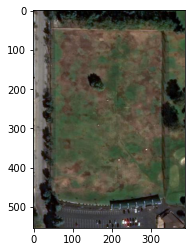

In [31]:
print(dataset_val.image_arr[6])
plt.imshow(Image.open(dataset_val.image_arr[6]))

In [17]:
dataset_val.label_arr[differ]

array([ 5, 21,  2, 28, 61, 29, 30, 36, 37,  6, 14, 23, 22, 39, 18,  4, 14,
       60, 48, 11,  8, 19, 40, 17, 40, 30, 37, 22,  1,  8, 37, 19, 36, 17,
       34, 47,  7, 37, 14, 35, 33, 23, 29])

In [25]:
os.makedirs('figures/sample_img', exist_ok=True)

In [33]:
for i in differ:
    im_path = dataset_val.image_arr[i]
    im = Image.open(im_path)
    im.save(f'figures/sample_img/{i}.jpg')
    info = {
        'img_net_pred': CATEGORIES[int(pred1[i])],
        'fmow_pred': CATEGORIES[int(pred2[i])],
        'gt': CATEGORIES[int(true[i])],
        'img_net_correct': bool(correct1[i])
    }
    print(info)
    with open(f'figures/sample_img/{i}.json', 'w') as f:
        json.dump(info, f)

{'img_net_pred': 'surface_mine', 'fmow_pred': 'archaeological_site', 'gt': 'archaeological_site', 'img_net_correct': False}
{'img_net_pred': 'golf_course', 'fmow_pred': 'park', 'gt': 'golf_course', 'img_net_correct': True}
{'img_net_pred': 'airport_terminal', 'fmow_pred': 'border_checkpoint', 'gt': 'airport_terminal', 'img_net_correct': True}
{'img_net_pred': 'lighthouse', 'fmow_pred': 'golf_course', 'gt': 'lighthouse', 'img_net_correct': True}
{'img_net_pred': 'zoo', 'fmow_pred': 'amusement_park', 'gt': 'zoo', 'img_net_correct': True}
{'img_net_pred': 'military_facility', 'fmow_pred': 'educational_institution', 'gt': 'military_facility', 'img_net_correct': True}
{'img_net_pred': 'debris_or_rubble', 'fmow_pred': 'multi-unit_residential', 'gt': 'multi-unit_residential', 'img_net_correct': False}
{'img_net_pred': 'multi-unit_residential', 'fmow_pred': 'place_of_worship', 'gt': 'place_of_worship', 'img_net_correct': False}
{'img_net_pred': 'multi-unit_residential', 'fmow_pred': 'police_st

In [35]:
both_wrong = torch.nonzero(((correct1 == 0) & (correct2 == 0)).float()).view(-1)
print(both_wrong)

tensor([ 11,  12,  20,  21,  29,  34,  36,  52,  57,  60,  62,  74,  79,  86,
         91,  93,  95,  96, 100, 101, 108, 113, 130, 135, 142, 159, 161, 162,
        163, 178, 185, 193, 194, 199, 205])


In [36]:
for i in both_wrong:
    im_path = dataset_val.image_arr[i]
    im = Image.open(im_path)
    im.save(f'figures/sample_img/{i}.jpg')
    info = {
        'img_net_pred': CATEGORIES[int(pred1[i])],
        'fmow_pred': CATEGORIES[int(pred2[i])],
        'gt': CATEGORIES[int(true[i])],
        'img_net_correct': bool(correct1[i])
    }
    print(info)
    with open(f'figures/sample_img/{i}.json', 'w') as f:
        json.dump(info, f)

{'img_net_pred': 'barn', 'fmow_pred': 'fire_station', 'gt': 'office_building', 'img_net_correct': False}
{'img_net_pred': 'debris_or_rubble', 'fmow_pred': 'border_checkpoint', 'gt': 'hospital', 'img_net_correct': False}
{'img_net_pred': 'storage_tank', 'fmow_pred': 'tower', 'gt': 'debris_or_rubble', 'img_net_correct': False}
{'img_net_pred': 'single-unit_residential', 'fmow_pred': 'single-unit_residential', 'gt': 'airport_hangar', 'img_net_correct': False}
{'img_net_pred': 'waste_disposal', 'fmow_pred': 'prison', 'gt': 'zoo', 'img_net_correct': False}
{'img_net_pred': 'police_station', 'fmow_pred': 'police_station', 'gt': 'hospital', 'img_net_correct': False}
{'img_net_pred': 'parking_lot_or_garage', 'fmow_pred': 'parking_lot_or_garage', 'gt': 'place_of_worship', 'img_net_correct': False}
{'img_net_pred': 'electric_substation', 'fmow_pred': 'office_building', 'gt': 'smokestack', 'img_net_correct': False}
{'img_net_pred': 'single-unit_residential', 'fmow_pred': 'single-unit_residential'